# Inference acceleration of `T5` for large batch size / long sequence length / > large models

Every week or so, a new impressive few shots learning work taking advantage of auto regressive models are released by some team around the world.
Still inference is rarely discussed and few projects are focusing on this aspect.
In this notebook, we describe our take to significantly improve autoregressive model latency.

We plan to use large auto regressive models in production, so we want something:

* which scales: the improvement exists on small and large models, for short and long sequences, in greedy and beam search;
    * This is very important in a few shots learning where sequences are most of the time hundreds or thousands tokens long and beam search is used to improve text quality.
* that has no hidden cost: no big increase in memory usage, no degradation in quality of generated text, support state of the art decoding algorithms;
* that is generic: works for any transformer based architecture, and not specific to an inference engine;
* that is easy to maintain: no hard-coded behaviors or other technical debt if it doesn't bring a clear advantage.

To be clear, we are not targeting the best performance ever but the right trade off (for us at least) between simplicity to use/maintain and acceptable latency.

## The challenge

In most situations, performing inference with `Onnx Runtime` or `TensorRT` usually bring large improvement over `Pytorch` implementations.
It's very true with `transformer` based models.

The main reason is that these tools will perform kernel fusions (merging several operations into a single one) and therefore reduce the number of memory bounded operations. Sometimes they also replace some operations by a much faster approximation.
In the very specific case of autoregressive languages, things are a bit more complicated.

On most `Pytorch` implementations of these models, there is a `cache` of `K` and `V` values.
Let's remind us that in attention blocks, each token is projected on 3 matrices called `Query`, `Key`, and `Value`.
Then, those projections will be used to compute a representation of each token which takes into account all the other tokens of the sequence.

As autoregressive models generate the sequence one token at a time, they should recompute final representation of all past tokens for each new token to generate.
Because each token can only attend to the past, the result of these computations never changes; therefore one simple trick to reduce latency is to just memorize them and reuse them later, avoiding lots of computation.

Out of the box, the cache mechanism can't be exported to `Onnx` from `Hugging Face` models (and all other `Pytorch` implementations we are aware of).
The reason is that those models are not `torchscript` scripting compliant (it requires `Pytorch` code to follow some [restrictive rules](https://pytorch.org/docs/stable/jit_builtin_functions.html)).
Because of that, `Onnx` export is done through `tracing` which erases any control flow instructions (including the `If` instruction to enable or not a cache).

## Existing solutions

Some interesting solutions targeting inference latency that we have considered and/or tested:

* [TensorRT](https://developer.nvidia.com/blog/optimizing-t5-and-gpt-2-for-real-time-inference-with-`TensorRT`/), which targets `GPU`, heavily optimizes the computation graph, making `T5` inference very fast (they report X10 speedup on `small-T5`). The trick is that it doesn't use any cache (see below for more details), so it's very fast on short sequence and small models, as it avoids many memory bounded operations by redoing full computation again and again... but as several users have already found ([1](https://github.com/NVIDIA/TensorRT/issues/1807), [2](https://github.com/NVIDIA/TensorRT/issues/1642), [3](https://github.com/NVIDIA/TensorRT/issues/1799), [4](https://github.com/NVIDIA/TensorRT/issues/1845), ...), this approach doesn't scale when the computation intensity increases, ie when base or large models are used instead of small one, when generation is done on moderately long sequence of few hundred of tokens or if beam search is used instead of greedy search;
* [FastT5](https://github.com/Ki6an/fastT5), which targets `CPU`, exports 2 versions of the decoder, one with cache and one without. You need the `no cache` version to compute the first token and the first `past state` tensors (aka the cached tensors), and for all the other tokens you use the `cache` version of the computation graph. Basically, it makes the memory foot print 2 times bigger as all weights are duplicated. As generative models tend to be huge, they work around the memory issue by using dynamic `int-8` quantization, the final memory foot print of the decoders is now the same as Hugging Face in `FP16`... but 1/ dynamic quantization only work on `CPU`, and 2/ according to several reports dynamic quantization degrades significantly generative model output, to a point where it may make them useless ([1](https://github.com/huggingface/transformers/issues/2466#issuecomment-572781378), [2](https://github.com/huggingface/transformers/issues/2466#issuecomment-982710520), and [here](https://github.com/microsoft/onnxruntime/issues/6549#issuecomment-1016948837) you can find a report in the `GPT-2` context from a Microsoft engineer: "*int8 quantization are not recommended due to accuracy loss*").
* [Onnx Runtime T5 export tool](https://github.com/microsoft/onnxruntime/tree/master/onnxruntime/python/tools/transformers/models/t5) targets both `GPU` and `CPU`. It works in a similar way than `FastT5`: `decoder` module is exported 2 times. Like `FastT5`, the memory footprint of the decoder part is doubled (this time there is no `int-8` quantization).
* [FasterTransformer](https://github.com/NVIDIA/FasterTransformer/blob/main/docs/t5_guide.md#translation-process) targets `GPU` and is a mix of `Pytorch` and CUDA/C++ dedicated code. The performance boost is huge on `T5`, they report a 10X speedup like TensorRT. However, it may significantly decrease the accuracy of the model ([here](https://github.com/NVIDIA/FasterTransformer/blob/main/docs/t5_guide.md#translation-process) when sampling is enabled, it reduces BLEU score of translation task by 8 points) plus the speedup is computed on a [translation task](https://github.com/NVIDIA/FasterTransformer/blob/main/examples/pytorch/decoding/utils/translation/test.en) where sequences are 25 tokens long on average. In our experience, improvement on very short sequences tends to decrease by large margins on longer sequences. It seems to us that their objectives are different from ours.

With the existing solutions, you need to choose one or two items of the following:

* double decoder memory footprint;
* be slower than Hugging Face for moderatly long sequence length / beam search;
* degrade output quality.

## Our approach

Our approach to make autoregressive `transformer` based models 2X faster than Hugging Face Pytorch implementation (the base line) is based on 3 key ingredients:

* storing 2 computation graph in a single Onnx file: this let us have both cache and no cache support without having any duplicated weights,
* `zero copy` to retrieve output from Onnx Runtime: we built over our past work to connect in the most efficient way `Pytorch` tensors (used in the decoding part) and `Onnx Runtime`. Our previous work was to avoid host <-> `GPU` tensor copy, but it still required a `GPU` <-> `GPU`. It is now part of the official Onnx Runtime documentation (apparently [thanks of our project](https://github.com/microsoft/onnxruntime/pull/10651)!). This time we found out a way to directly expose the internal state of `Onnx Runtime` through a `Pytorch` tensor in zero copy way. Combined with cache mechanism, this is responsible for most of the speedup we have obtained.
* a generic tool to convert any model (whatever the architecture) to `FP16` without any risk of having out of range values or rounding to zero: `FP16` is still the way to reduce memory footprint of a model. The main issue is that some nodes may output values outside of `FP16` range or round others to zero, resulting in `NaN` output, moreover very small values may be rounded to zero which is an issue for log and div operations. We have built a tool which detect those nodes so we can keep their precision in `FP32`. It's quite important to reduce memory footprint of these models, not just because they tend to be huge, but also because past states (that we cache) and internal buffers can be even bigger than the weights of the model themselves.

## Results

As demonstrated at the end of this notebook, **we are able to provide a X2 speedup** whatever the batch size, the sequence length or the model size.

> for `TensorRT` we have our own implementation of our approach described above which helps to provide similar latency to `Onnx Runtime`. It's in a Python script in the same folder as this notebook. We had to work around a documented limitation. Because of that the code is slightly more complex and we wanted to keep this notebook easy to follow.


In [1]:
! nvidia-smi

Sun May 22 12:34:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
| 33%   44C    P8    28W / 350W |     93MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Onnx Runtime compilation

Version 1.11.1 of Onnx Runtime and older have a bug which makes them much slower when most inputs are used by subgraphs of an `If` node.
Unfortunately, it's exactly what will do below, so we need to compile our own version of Onnx Runtime until the version 1.12 is released (in June 2022).
Code below has been tested on Ubuntu 22.04 and supposes that your machine has CUDA 11.4 installed.
If not, use the Docker image of this library.

We use a specific commit of Onnx Runtime with a better management of if/else/then Onnx node:

```shell
git clone --recursive https://github.com/Microsoft/onnxruntime
cd onnxruntime
git checkout -b fix_if e1c04eed29d48f295de1cfbd48713158537cdaa7
CUDACXX=/usr/local/cuda-11.4/bin/nvcc ./build.sh \
    --config Release \
    --build_wheel \
    --parallel \
    --use_cuda \
    --cuda_home /usr/local/cuda-11.4 \
    --cudnn_home /usr/lib/x86_
    -linux-gnu/ \
    --skip_test
```

On our machine, it takes around 20 minutes.

> to clear previous compilation, delete content of `./build` folder

In [2]:
import json
import random
from transformer_deploy.backends.ort_utils import get_keep_fp32_nodes
from transformer_deploy.backends.ort_utils import convert_fp16
from time import time
from typing import Callable, Dict, Optional, List
import matplotlib.pylab as plt
from onnxruntime import IOBinding
import numpy as np
import onnx
import torch
from pathlib import Path
from typing import Tuple
from onnx import GraphProto, ModelProto, helper
from torch.nn import Linear
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, PretrainedConfig, T5ForConditionalGeneration, TensorType
from transformers.generation_utils import GenerationMixin
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions, Seq2SeqLMOutput
from transformers.models.t5.modeling_t5 import T5Stack
from nvtx import nvtx
from copy import copy

from transformer_deploy.backends.ort_utils import create_model_for_provider, inference_onnx_binding
from transformer_deploy.backends.pytorch_utils import convert_to_onnx
import seaborn as sns
import operator
from collections import defaultdict
import gc

## Loading Hugging Face model / tokenizer

Below we load the model and set global variables of this notebook.

In [3]:
np.random.seed(123)
torch.random.manual_seed(123)
# other possible values: t5-small, t5-base, t5-large. t5-3b should work when ORT library is fixed
model_name = "t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
input_ids: torch.Tensor = tokenizer(
    "translate English to French: This model is now very fast!", return_tensors=TensorType.PYTORCH
).input_ids
input_ids = input_ids.type(torch.int32).to("cuda")
pytorch_model: T5ForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(model_name)
pytorch_model = pytorch_model.eval()
pytorch_model = pytorch_model.cuda()
pytorch_model.config.use_cache = True  # not really needed, just to make things obvious
num_layers = pytorch_model.config.num_layers
# tolerance between Onnx FP16 and Pytorch FP32.
# Rounding errors increase with number of layers: 1e-1 for t5-small, 5e-1 for large, 3 for 3b. 11b not tested.
# Do not impact final quality
fp16_default_tolerance = 5e-1


def are_equal(a: torch.Tensor, b: torch.Tensor, atol: float = fp16_default_tolerance) -> None:
    assert np.allclose(a=a.detach().cpu().numpy(), b=b.detach().cpu().numpy(), atol=atol), f"{a}\n\nVS\n\n{b}"


def save_onnx(proto: onnx.ModelProto, f: str):
    # protobuff doesn't support files > 2Gb, in this case, weights are stored in another binary file
    save_external_data: bool = proto.ByteSize() > 2 * 1024**3
    filename = Path(f).name
    onnx.save_model(
        proto=proto,
        f=f,
        save_as_external_data=save_external_data,
        all_tensors_to_one_file=True,
        location=filename + ".data",
    )


def prepare_folder(path: str) -> Tuple[str, str]:
    p = Path(path)
    p.mkdir(parents=True, exist_ok=True)
    [item.unlink() for item in Path(path).glob("*") if item.is_file()]
    return path + "/model.onnx", path + "/model_fp16.onnx"


# create/clean folders where each model will be stored.
# as multiple files will be saved for T5-3B and 11B, we use different folders for the encoder and the decoders.
encoder_model_path, encoder_fp16_model_path = prepare_folder(path="./test-enc")
dec_cache_model_path, dec_cache_fp16_model_path = prepare_folder(path="./test-dec-cache")
dec_no_cache_model_path, dec_no_cache_fp16_model_path = prepare_folder(path="./test-dec-no-cache")
_, dec_if_fp16_model_path = prepare_folder(path="./test-dec-if")

# some outputs to compare with
out_enc: BaseModelOutputWithPastAndCrossAttentions = pytorch_model.encoder(input_ids=input_ids)
out_full: Seq2SeqLMOutput = pytorch_model(input_ids=input_ids, decoder_input_ids=input_ids)

# Export to Onnx

First step is to export the model to Onnx graph.
`T5` is made of 2 parts, an `encoder` and a `decoder`.

## Export encoder part

The `encoder` part export doesn't imply any specific challenge.
We use export function built for `Bert` like model, exported model is in `FP16`.

In [4]:
pytorch_model = pytorch_model.to("cuda")

convert_to_onnx(
    model_pytorch=pytorch_model.encoder,
    output_path=encoder_model_path,
    inputs_pytorch={"input_ids": input_ids},
    var_output_seq=True,
    quantization=False,
)

## Conversion to mixed precision

### Why mixed precision?

As `T5` can have up to 11 billion parameters, it requires lots of computation, and even more important, it takes lots of space in device memory.
We convert the `encoder` to half precision.

Half precision covers a lower range of values compared to FP32 as we have 2 times fewer bits to encode them.
If we just convert everything to FP16, we will have 2 issues:
* `overflow`: some nodes, like exponential nodes, will try to output values out of the FP16 range, it will be replaced by infinite value or NaN (depending of the inference engine).
* `underflow`: values very close to 0 will be rounded to 0. It may be an issue for some nodes like logarithms and divisions.

### The challenge

Mixed precision is done out of the box by Pytorch and follow some strict rules described in https://pytorch.org/docs/stable/amp.html?utm_source=pocket_mylist

Those rules are generic and quite conservative. Many nodes will be kept in FP32 even if their output is always in the FP16 range.

Other approaches we have found:
* `Onnxruntime T5` [demo](https://github.com/microsoft/onnxruntime/blob/master/onnxruntime/python/tools/transformers/models/t5/t5_helper.py): provide a list of operations to keep in FP32 (Pow, ReduceMean, Add, Sqrt, Div, Mul, Softmax, Relu). We have found this approach to need more an more tweaking on larger networks and encoder part (decoder part seems simpler to manage, https://github.com/microsoft/onnxruntime/issues/11119);
* `TensorRT T5` [demo](https://github.com/NVIDIA/TensorRT/tree/main/demo/HuggingFace/notebooks): provide the exact pattern of nodes to keep in FP32. This approach is much more effective, but imply lots of code to describe the patterns and may not generalize well, basically what works for a `base` model may not work for 11 billion parameters model. And it does not scale to other architectures without adaptations, for a library like `transformer-deploy`, it would lead to unmaintainable technical debt.


### Our approach

We have chosen an architecture agnostic approach: we inject random input sequences and audit the output of each computation graph node; finally we make a list of all nodes that have output values out of the FP16 range /close to zero values and perform some cleaning (to avoid unnecessary casting).

We have chosen to use random values only for the `input_ids` field as the search space is limited: positive integers lower than the vocabulary size.
You can also decide to send real data from a dataset you want to work on.

To finish, we provide the list of nodes to keep in FP32 to the conversion function.

In [5]:
def get_random_input_encoder() -> Dict[str, torch.Tensor]:
    max_seq = 512
    seq_len = random.randint(a=1, b=max_seq)
    batch = max_seq // seq_len
    random_input_ids = torch.randint(
        low=0, high=tokenizer.vocab_size, size=(batch, seq_len), dtype=torch.int32, device="cuda"
    )
    inputs = {"input_ids": random_input_ids}
    return inputs


keep_fp32_encoder = get_keep_fp32_nodes(onnx_model_path=encoder_model_path, get_input=get_random_input_encoder)
assert len(keep_fp32_encoder) > 0
enc_model_onnx = convert_fp16(onnx_model=encoder_model_path, nodes_to_exclude=keep_fp32_encoder)
save_onnx(proto=enc_model_onnx, f=encoder_fp16_model_path)

del enc_model_onnx
torch.cuda.empty_cache()
gc.collect()

3768

In [6]:
print(f"20 first nodes to keep in FP32 (total {len(keep_fp32_encoder)}):")
keep_fp32_encoder[:20]

20 first nodes to keep in FP32 (total 1229):


['Pow_29',
 'Log_89',
 'Div_91',
 'Mul_93',
 'Softmax_109',
 'Pow_120',
 'Pow_135',
 'Mul_143',
 'Softmax_168',
 'Pow_179',
 'Pow_194',
 'Softmax_227',
 'Pow_238',
 'Pow_253',
 'Softmax_286',
 'Pow_297',
 'Pow_312',
 'Mul_319',
 'Mul_320',
 'Softmax_345']

Compare the output of the FP16 model with Pytorch one

In [7]:
enc_fp16_onnx = create_model_for_provider(encoder_fp16_model_path, "CUDAExecutionProvider")
enc_fp16_onnx_binding: IOBinding = enc_fp16_onnx.io_binding()
enc_onnx_out = inference_onnx_binding(
    model_onnx=enc_fp16_onnx,
    binding=enc_fp16_onnx_binding,
    inputs={"input_ids": input_ids},
    device=input_ids.device.type,
)["output"]
are_equal(a=enc_onnx_out, b=out_enc.last_hidden_state)

## Export decoder

The decoder export part is more challenging:

* we first need to wrap it in a `Pytorch` model to add the final layer so it's output provide scores for each vocabulary token and can be directly used by the Hugging Face `decoding` algorithm
* then, we need to manipulate the `Onnx` graph to add support of `Key`/`Value` cache

The second point is the key ingredient of the observed acceleration of `Onnx` vs Hugging Face inference.


### Wrapper to include some post-processing on the decoder output

The post-processing is mainly a projection of the decoder output on a matrix with one of its dimensions equal to model vocabulary size, so we have scores for each possible token.

In [8]:
class ExportT5(torch.nn.Module):
    def __init__(self, decoder: T5Stack, lm_head: Linear):
        super(ExportT5, self).__init__()
        self.decoder = decoder
        self.lm_head = lm_head

    def forward(self, input_ids: torch.Tensor, encoder_hidden_states: torch.Tensor, past_key_values: Tuple = None):
        out_dec = self.decoder.forward(
            input_ids=input_ids, encoder_hidden_states=encoder_hidden_states, past_key_values=past_key_values
        )
        # Rescale output before projecting on vocab
        out_dec["last_hidden_state"] = out_dec["last_hidden_state"] * (pytorch_model.model_dim**-0.5)
        out_dec["last_hidden_state"] = self.lm_head(out_dec["last_hidden_state"])
        return out_dec


pytorch_model.cuda()
model_decoder = ExportT5(decoder=pytorch_model.decoder, lm_head=pytorch_model.lm_head).eval()
out_model_export: torch.Tensor = model_decoder(input_ids=input_ids, encoder_hidden_states=out_enc.last_hidden_state)

are_equal(a=out_model_export["last_hidden_state"], b=out_full.logits)

### Export decoder part to `Onnx`

Below we export 2 versions of the decoder, one without cache support and one with it.

Model inputs with past states (cache support):

In [9]:
model_decoder.cuda()
# decoder output one step before
out_dec_pytorch = model_decoder(input_ids=input_ids[:, :-1], encoder_hidden_states=out_enc.last_hidden_state)

model_inputs = {
    "input_ids": input_ids[:, -1:].type(torch.int32),
    "encoder_hidden_states": out_enc.last_hidden_state,
    "past_key_values": out_dec_pytorch.past_key_values,
}

input_names = ["input_ids", "encoder_hidden_states"]

for i in range(num_layers):
    input_names.append(f"past_key_values.{i}.decoder.key")
    input_names.append(f"past_key_values.{i}.decoder.value")
    input_names.append(f"past_key_values.{i}.encoder.key")
    input_names.append(f"past_key_values.{i}.encoder.value")

output_names = ["logits"]

for i in range(num_layers):
    output_names.append(f"present.{i}.decoder.key")
    output_names.append(f"present.{i}.decoder.value")
    output_names.append(f"present.{i}.encoder.key")
    output_names.append(f"present.{i}.encoder.value")

dynamic_axis = {
    "input_ids": {0: "batch", 1: "encoder_sequence"},
    "encoder_hidden_states": {0: "batch", 1: "encoder_sequence"},
    "logits": {0: "batch", 1: "decoder_sequence"},
}


for i in range(num_layers):
    dynamic_axis[f"past_key_values.{i}.decoder.key"] = {0: "batch", 2: "past_decoder_sequence"}
    dynamic_axis[f"past_key_values.{i}.decoder.value"] = {0: "batch", 2: "past_decoder_sequence"}
    dynamic_axis[f"past_key_values.{i}.encoder.key"] = {0: "batch", 2: "encoder_sequence_length"}
    dynamic_axis[f"past_key_values.{i}.encoder.value"] = {0: "batch", 2: "encoder_sequence_length"}

    dynamic_axis[f"present.{i}.decoder.key"] = {0: "batch", 2: "decoder_sequence"}
    dynamic_axis[f"present.{i}.decoder.value"] = {0: "batch", 2: "decoder_sequence"}
    dynamic_axis[f"present.{i}.encoder.key"] = {0: "batch", 2: "encoder_sequence_length"}
    dynamic_axis[f"present.{i}.encoder.value"] = {0: "batch", 2: "encoder_sequence_length"}

Export of the model with cache support:

In [10]:
with torch.no_grad():
    pytorch_model.config.return_dict = True
    pytorch_model.eval()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    torch.onnx.export(
        model_decoder,
        (model_inputs,),
        f=dec_cache_model_path,
        input_names=input_names,
        output_names=output_names,
        dynamic_axes=dynamic_axis,
        do_constant_folding=True,
        opset_version=13,
    )

/home/geantvert/.local/share/virtualenvs/fast_transformer/lib/python3.9/site-packages/transformers/modeling_utils.py:529: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if causal_mask.shape[1] < attention_mask.shape[1]:
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode


Export of the model computing Key/Values for the whole sequence (we basically just remove past states from the input, the Pytorch code will recompute them):

In [11]:
model_inputs_no_cache = {
    "input_ids": input_ids,
    "encoder_hidden_states": out_enc.last_hidden_state,
}

with torch.no_grad():
    pytorch_model.config.return_dict = True
    pytorch_model.eval()

    # export can works with named args but the dict containing named args as to be last element of the args tuple
    torch.onnx.export(
        model_decoder,
        (model_inputs_no_cache,),
        f=dec_no_cache_model_path,
        input_names=list(model_inputs_no_cache.keys()),
        output_names=output_names,
        dynamic_axes={k: v for k, v in dynamic_axis.items() if "past_key_values" not in k},
        do_constant_folding=True,
        opset_version=13,
    )
_ = pytorch_model.cpu()  # free cuda memory
torch.cuda.empty_cache()

## Conversion to mixed precision

Decoder module has different kinds of inputs, `input_ids` but also some float tensors.
It would a bit more complicated to generate random values for those tensors: in theory it can be of any value in the FP32 range, but because of how models are initialized and trained, most of them are close to 0.

To avoid too  much guessing, we have decided to just take the output of the real model being fed with random `input_ids`.


In [12]:
def get_random_input_no_cache() -> Dict[str, torch.Tensor]:
    inputs = get_random_input_encoder()
    encoder_hidden_states = inference_onnx_binding(
        model_onnx=enc_fp16_onnx,
        binding=enc_fp16_onnx_binding,
        inputs=inputs,
        device="cuda",
        clone_tensor=False,
    )["output"]
    # it will serve as input of a FP32 model
    inputs["encoder_hidden_states"] = encoder_hidden_states.type(torch.float32)
    return inputs


keep_fp32_no_cache = get_keep_fp32_nodes(onnx_model_path=dec_no_cache_model_path, get_input=get_random_input_no_cache)

onnx_model_no_cache_fp16 = convert_fp16(onnx_model=dec_no_cache_model_path, nodes_to_exclude=keep_fp32_no_cache)
save_onnx(onnx_model_no_cache_fp16, dec_no_cache_fp16_model_path)

In [13]:
print(f"20 first nodes to keep in FP32 (total {len(keep_fp32_no_cache)}):")
keep_fp32_no_cache[:20]

20 first nodes to keep in FP32 (total 2359):


['Constant_74',
 'Pow_78',
 'Log_135',
 'Div_137',
 'Mul_139',
 'Softmax_154',
 'Pow_165',
 'Softmax_212',
 'Pow_223',
 'Pow_238',
 'MatMul_250',
 'Reshape_254',
 'Transpose_255',
 'Softmax_272',
 'Pow_283',
 'MatMul_295',
 'Reshape_299',
 'Transpose_300',
 'Softmax_317',
 'Pow_328']

In [14]:
dec_no_cache_ort_model = create_model_for_provider(dec_no_cache_model_path, "CUDAExecutionProvider")

# use info from tokenizer size and max shape provided through the command line
def get_random_input_cache() -> Dict[str, torch.Tensor]:
    inputs = get_random_input_no_cache()
    dec_past_states = inference_onnx_binding(
        model_onnx=dec_no_cache_ort_model,
        inputs=inputs,
        device="cuda",
        clone_tensor=False,
    )
    for k, v in dec_past_states.items():
        if k == "logits":
            continue
        new_k = k.replace("present", "past_key_values")
        inputs[new_k] = v
    batch, _ = inputs["input_ids"].shape
    complement = torch.randint(low=0, high=tokenizer.vocab_size, size=(batch, 1), dtype=torch.int32, device="cuda")
    inputs["input_ids"] = torch.concat(tensors=[inputs["input_ids"], complement], dim=1)
    return inputs


keep_fp32_cache = get_keep_fp32_nodes(onnx_model_path=dec_cache_model_path, get_input=get_random_input_cache)
del dec_no_cache_ort_model  # free cuda memory
torch.cuda.empty_cache()
gc.collect()

onnx_model_cache_fp16 = convert_fp16(onnx_model=dec_cache_model_path, nodes_to_exclude=keep_fp32_cache)
save_onnx(onnx_model_cache_fp16, dec_cache_fp16_model_path)

In [15]:
print(f"20 first nodes to keep in FP32 (total {len(keep_fp32_cache)}):")
keep_fp32_cache[:20]

20 first nodes to keep in FP32 (total 2303):


['Constant_94',
 'Pow_98',
 'Log_161',
 'Div_163',
 'Mul_165',
 'Softmax_188',
 'Pow_202',
 'Mul_210',
 'Softmax_246',
 'Pow_257',
 'Pow_272',
 'Softmax_308',
 'Pow_319',
 'Softmax_341',
 'Pow_352',
 'Pow_367',
 'Softmax_403',
 'Pow_414',
 'MatMul_426',
 'Reshape_430']

## Merge `Onnx` computation graph to deduplicate weights

Finally, we will merge the 2 decoders together.
The idea is simple:

* we prefix the node / edge names of one of them to avoid naming collision
* we deduplicate the weights (the same weight matrix will have different names in the 2 models)
* we join the 2 computation graphs through an `If` node
* we generate the Onnx file

The new model will take a new input, `enable_cache`. When it contains a `True` value, computation graph with cache support is used.

> code below is written to be easy to read, but could be made much faster to run

In [16]:
prefix = "cache_node_"
mapping_initializer_cache_to_no_cache = dict()
to_add = list()
for node_cache in onnx_model_cache_fp16.graph.initializer:
    found = False
    for node_no_cache in onnx_model_no_cache_fp16.graph.initializer:
        if node_cache.raw_data == node_no_cache.raw_data:
            found = True
            mapping_initializer_cache_to_no_cache[node_cache.name] = node_no_cache.name
            break
    if not found:
        node_cache.name = prefix + node_cache.name
        to_add.append(node_cache)
        mapping_initializer_cache_to_no_cache[node_cache.name] = node_cache.name

onnx_model_no_cache_fp16.graph.initializer.extend(to_add)
# I/O model names should not be prefixed
model_io_names = [n.name for n in list(onnx_model_cache_fp16.graph.input) + list(onnx_model_cache_fp16.graph.output)]

for node in onnx_model_cache_fp16.graph.node:
    for index, input_name in enumerate(node.input):
        if input_name in model_io_names:
            continue
        node.input[index] = mapping_initializer_cache_to_no_cache.get(input_name, prefix + input_name)
    for index, output_name in enumerate(node.output):
        if output_name in model_io_names:
            continue
        node.output[index] = prefix + output_name
    node.name = prefix + node.name
model_io_names = [n.name for n in list(onnx_model_cache_fp16.graph.input) + list(onnx_model_cache_fp16.graph.output)]

prefix = "init_"
cache = dict()
for node in onnx_model_no_cache_fp16.graph.initializer:
    if node.name in model_io_names:
        new_name = prefix + node.name
        cache[node.name] = new_name
        node.name = new_name

for node in onnx_model_no_cache_fp16.graph.node:
    for input_index, n in enumerate(node.input):
        node.input[input_index] = cache.get(n, n)

# mandatory for subgraph in if/else node
assert len(onnx_model_cache_fp16.graph.output) == len(
    onnx_model_no_cache_fp16.graph.output
), f"{len(onnx_model_cache_fp16.graph.output)} vs {len(onnx_model_no_cache_fp16.graph.output)}"

graph_cache: onnx.GraphProto = onnx.helper.make_graph(
    nodes=list(onnx_model_cache_fp16.graph.node),
    name="graph-cache",
    inputs=[],
    outputs=list(onnx_model_cache_fp16.graph.output),
    initializer=[],
)

graph_no_cache: onnx.GraphProto = onnx.helper.make_graph(
    nodes=list(onnx_model_no_cache_fp16.graph.node),
    name="graph-no-cache",
    inputs=[],
    outputs=list(onnx_model_no_cache_fp16.graph.output),
    initializer=[],
)

enable_cache_input = onnx.helper.make_tensor_value_info(name="enable_cache", elem_type=onnx.TensorProto.BOOL, shape=[1])

if_node = onnx.helper.make_node(
    op_type="If",
    inputs=["enable_cache"],
    outputs=[o.name for o in list(onnx_model_no_cache_fp16.graph.output)],
    then_branch=graph_cache,
    else_branch=graph_no_cache,
)

if_graph_def: GraphProto = helper.make_graph(
    nodes=[if_node],
    name="if-model",
    inputs=list(onnx_model_cache_fp16.graph.input) + [enable_cache_input],
    outputs=list(onnx_model_no_cache_fp16.graph.output),
    initializer=list(onnx_model_no_cache_fp16.graph.initializer),
)


model_if: ModelProto = helper.make_model(
    if_graph_def, producer_name="onnx-example", opset_imports=[helper.make_opsetid(onnx.defs.ONNX_DOMAIN, 13)]
)
save_onnx(model_if, dec_if_fp16_model_path)
del model_if
torch.cuda.empty_cache()
gc.collect()

6387

### Check `Onnx` decoder output

Compare `Onnx` output with and without cache, plus compare with `Pytorch` output.

In [17]:
pytorch_model = pytorch_model.cuda()
model_decoder = model_decoder.cuda()
input_ids = input_ids.cuda()
pytorch_model = pytorch_model.eval()
model_decoder = model_decoder.eval()
dec_onnx = create_model_for_provider(dec_if_fp16_model_path, "CUDAExecutionProvider", log_severity=3)
dec_onnx_binding: IOBinding = dec_onnx.io_binding()

## Output testing of the new model

Below, we check that the new model output are similar to the ones from `Pytorch`.

In [18]:
pytorch_model = pytorch_model.half()
with torch.inference_mode():
    out_enc_pytorch: BaseModelOutputWithPastAndCrossAttentions = pytorch_model.encoder(input_ids=input_ids)
    previous_step_pytorch: BaseModelOutputWithPastAndCrossAttentions = model_decoder(
        input_ids=input_ids[:, :-1], encoder_hidden_states=out_enc_pytorch.last_hidden_state
    )
    out_dec_pytorch: BaseModelOutputWithPastAndCrossAttentions = model_decoder(
        input_ids=input_ids, encoder_hidden_states=out_enc_pytorch.last_hidden_state
    )

In [19]:
def decoder_pytorch_inference(decoder_input_ids: torch.Tensor, encoder_hidden_states: torch.Tensor, **_):
    with torch.inference_mode():
        return model_decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_hidden_states)


def decoder_onnx_inference(
    decoder_input_ids: torch.Tensor,
    encoder_hidden_states: torch.Tensor,
    enable_cache: torch.Tensor,
    past_key_values: Optional[torch.Tensor],
):
    inputs_onnx_dict = {
        "input_ids": decoder_input_ids,
        "encoder_hidden_states": encoder_hidden_states,
        "enable_cache": enable_cache,
    }

    if past_key_values is not None:
        for index, (k_dec, v_dec, k_enc, v_enc) in enumerate(past_key_values):
            inputs_onnx_dict[f"past_key_values.{index}.decoder.key"] = k_dec
            inputs_onnx_dict[f"past_key_values.{index}.decoder.value"] = v_dec
            inputs_onnx_dict[f"past_key_values.{index}.encoder.key"] = k_enc
            inputs_onnx_dict[f"past_key_values.{index}.encoder.value"] = v_enc

    result_dict = inference_onnx_binding(
        model_onnx=dec_onnx,
        inputs=inputs_onnx_dict,
        binding=dec_onnx_binding,  # recycle the binding
        device=decoder_input_ids.device.type,
        clone_tensor=False,  # no memory copy -> best perf and lowest memory footprint!
    )
    past_states = list()
    for index in range(pytorch_model.config.num_layers):
        kv = (
            result_dict[f"present.{index}.decoder.key"],
            result_dict[f"present.{index}.decoder.value"],
            result_dict[f"present.{index}.encoder.key"],
            result_dict[f"present.{index}.encoder.value"],
        )
        past_states.append(kv)
    return BaseModelOutputWithPastAndCrossAttentions(
        last_hidden_state=result_dict["logits"],
        past_key_values=past_states,
    )


out_dec_onnx_no_cache = decoder_onnx_inference(
    decoder_input_ids=input_ids,
    encoder_hidden_states=out_enc_pytorch.last_hidden_state,
    enable_cache=torch.tensor([False], device="cuda", dtype=torch.bool),
    past_key_values=None,
)
are_equal(a=out_dec_onnx_no_cache.last_hidden_state[:, -1:, :], b=out_dec_pytorch.last_hidden_state[:, -1:, :])

# check that past states are identical between Onnx and Pytorch
assert len(out_dec_onnx_no_cache.past_key_values) == len(out_dec_pytorch.past_key_values)
for (o_dec_k, o_dev_v, o_enc_k, o_enc_v), (p_dec_k, p_dev_v, p_enc_k, p_enc_v) in zip(
    out_dec_onnx_no_cache.past_key_values, out_dec_pytorch.past_key_values
):
    are_equal(a=o_dec_k, b=p_dec_k)
    are_equal(a=o_dev_v, b=p_dev_v)
    are_equal(a=o_enc_k, b=p_enc_k)
    are_equal(a=o_enc_v, b=p_enc_v)

In [20]:
out_dec_onnx_cache = decoder_onnx_inference(
    decoder_input_ids=input_ids[:, -1:],
    encoder_hidden_states=out_enc_pytorch.last_hidden_state,
    enable_cache=torch.tensor([True], device="cuda", dtype=torch.bool),
    past_key_values=previous_step_pytorch.past_key_values,
)

are_equal(a=out_dec_onnx_cache.last_hidden_state[:, -1:, :], b=out_dec_pytorch.last_hidden_state[:, -1:, :])

# check that past states are identical between ONNX and Pytorch
assert len(out_dec_onnx_cache.past_key_values) == len(out_dec_pytorch.past_key_values)
for (o_dec_k, o_dev_v, o_enc_k, o_enc_v), (p_dec_k, p_dev_v, p_enc_k, p_enc_v) in zip(
    out_dec_onnx_cache.past_key_values, out_dec_pytorch.past_key_values
):
    are_equal(a=o_dec_k, b=p_dec_k)
    are_equal(a=o_dev_v, b=p_dev_v)
    are_equal(a=o_enc_k, b=p_enc_k)
    are_equal(a=o_enc_v, b=p_enc_v)

## Benchmarks!

Finally, we will compare the performances of 4 setup in end-to-end scenarii:

* `Pytorch`
* `Pytorch` + cache
* `Onnx`
* `Onnx` + cache

For the comparison, we first do a sanity check by just generating a short sequence (we already have checked that output tensors are OK).

Then we force each model to generate:

* 256 tokens + batch size 1 (similar to `TensorRT` demo)
* 1000 tokens + batch size 4


In [21]:
def encoder_onnx_inference(input_ids: torch.Tensor, **_) -> BaseModelOutputWithPastAndCrossAttentions:
    last_hidden_state = inference_onnx_binding(
        model_onnx=enc_fp16_onnx,  # noqa: F821
        inputs={"input_ids": input_ids},
        device=input_ids.device.type,
        binding=enc_fp16_onnx_binding,
    )["output"]
    return BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=last_hidden_state.type(torch.float16))


def encoder_pytorch_inference(input_ids, **_) -> BaseModelOutputWithPastAndCrossAttentions:
    with torch.inference_mode():
        res = pytorch_model.encoder(input_ids=input_ids).type(torch.float16)
        return res


# https://github.com/NVIDIA/TensorRT/blob/main/demo/HuggingFace/T5/export.py
class ExtT5(torch.nn.Module, GenerationMixin):
    def __init__(self, config: PretrainedConfig, device: torch.device, encoder_func: Callable, decoder_func: Callable):
        super(ExtT5, self).__init__()
        self.main_input_name = "input_ids"  # https://github.com/huggingface/transformers/pull/14803
        self.config: PretrainedConfig = config
        self.device: torch.device = device

        self.encoder_func = encoder_func
        self.decoder_func = decoder_func
        self.use_cache = True
        self.timings = list()

    def get_encoder(self):
        return self.encoder_func

    def get_decoder(self):
        return self.decoder_func

    def set_cache(self, enable: bool) -> None:
        self.use_cache = enable

    # from transformers library (modeling_t5.py)
    def _reorder_cache(self, past, beam_idx):
        reordered_decoder_past = ()
        for layer_past_states in past:
            # get the correct batch idx from layer past batch dim
            # batch dim of `past` is at 2nd position
            reordered_layer_past_states = ()
            for layer_past_state in layer_past_states:
                # need to set correct `past` for each of the four key / value states
                reordered_layer_past_states = reordered_layer_past_states + (
                    layer_past_state.index_select(0, beam_idx),
                )

            assert reordered_layer_past_states[0].shape == layer_past_states[0].shape
            assert len(reordered_layer_past_states) == len(layer_past_states)

            reordered_decoder_past = reordered_decoder_past + (reordered_layer_past_states,)
        return reordered_decoder_past

    def prepare_inputs_for_generation(self, input_ids, past=None, use_cache=None, **kwargs) -> Dict[str, torch.Tensor]:
        params = {
            "encoder_hidden_states": kwargs["encoder_outputs"]["last_hidden_state"],
        }
        if past is None:  # this is the 1st inferred token
            self.timings = list()
        if not self.use_cache:
            past = None
        if past is None:
            params[self.main_input_name] = input_ids
            params["enable_cache"] = torch.tensor([False], device="cuda", dtype=torch.bool)
        else:
            params[self.main_input_name] = input_ids[:, -1:]
            params["enable_cache"] = torch.tensor([True], device="cuda", dtype=torch.bool)
            params["past_key_values"] = past

        return params

    def forward(
        self,
        input_ids: torch.Tensor,
        encoder_hidden_states: torch.Tensor,
        enable_cache: torch.Tensor,
        past_key_values: Optional[torch.Tensor] = None,
        **_,
    ):
        start_timer = time()
        dec_output = self.get_decoder()(
            decoder_input_ids=input_ids,
            encoder_hidden_states=encoder_hidden_states,
            enable_cache=enable_cache,
            past_key_values=past_key_values,
        )
        self.timings.append(time() - start_timer)
        return Seq2SeqLMOutput(logits=dec_output.last_hidden_state, past_key_values=dec_output.past_key_values)


model_gen = (
    ExtT5(
        config=pytorch_model.config,
        device=pytorch_model.device,
        encoder_func=encoder_onnx_inference,  # encoder_pytorch_inference
        decoder_func=decoder_onnx_inference,  # decoder_pytorch_inference
    )
    .cuda()
    .eval()
)

torch.cuda.synchronize()
with torch.inference_mode():
    print("Onnx:")
    print(
        tokenizer.decode(
            model_gen.generate(
                inputs=input_ids,
                min_length=2,
                max_length=60,
                num_beams=4,
                no_repeat_ngram_size=2,
            )[0],
            skip_special_tokens=True,
        )
    )
    print("Pytorch:")
    print(
        tokenizer.decode(
            pytorch_model.generate(
                input_ids=input_ids,
                min_length=2,
                max_length=60,
                num_beams=4,
                no_repeat_ngram_size=2,
            )[0],
            skip_special_tokens=True,
        )
    )

Onnx:
Ce modèle est maintenant très rapide!
Pytorch:
Ce modèle est maintenant très rapide!


In [22]:
def print_timings(name: str, total: float, inference: float):
    percent_inference = 100 * inference / total
    print(f"{name}: {total:.1f}, including inference: {inference:.1f} ({percent_inference:.1f}%)")


all_timings: Dict[str, Dict[str, List[float]]] = dict()
for seq_len, num_beam in [(256, 1), (1000, 4)]:
    timings = dict()

    print(f"seq len: {seq_len} / # beam (batch size): {num_beam}")
    task = "Onnx"
    with nvtx.annotate(task, color="red"):  # nvtx is for Nvidia nsight profiler, you can remove the line or install the library
        model_gen.set_cache(enable=False)
        # warmup
        model_gen.generate(inputs=input_ids, max_length=10, num_beams=num_beam, min_length=10)
        start = time()
        model_gen.generate(inputs=input_ids, max_length=seq_len, num_beams=num_beam, min_length=seq_len)
        print_timings(name=task, total=time() - start, inference=sum(model_gen.timings))
        timings[f"{task}"] = model_gen.timings

    task = "Onnx + cache"
    with nvtx.annotate(task, color="red"):
        model_gen.set_cache(enable=True)
        # warmup
        model_gen.generate(inputs=input_ids, max_length=10, num_beams=num_beam, min_length=10)
        start = time()
        model_gen.generate(inputs=input_ids, max_length=seq_len, num_beams=num_beam, min_length=seq_len)
        print_timings(name=task, total=time() - start, inference=sum(model_gen.timings))
        timings[f"{task}"] = model_gen.timings

    # monckey patching of forward function to add a timer per generated token
    old_fw = pytorch_model.forward
    timing_pytorch = list()

    def new_fw(self, *args, **kwargs):
        timer_start = time()
        res = old_fw(self, *args, **kwargs)
        torch.cuda.synchronize()  # makes timings correct without having significant impact on e2e latency
        timing_pytorch.append(time() - timer_start)
        return res

    pytorch_model.forward = new_fw.__get__(pytorch_model)
    task = "Pytorch"
    with nvtx.annotate(task, color="orange"):
        pytorch_model.config.use_cache = False
        with torch.inference_mode():
            with torch.cuda.amp.autocast():
                # warmup
                pytorch_model.generate(inputs=input_ids, max_length=10, num_beams=num_beam, min_length=10)
                start = time()
                pytorch_model.generate(inputs=input_ids, max_length=seq_len, num_beams=num_beam, min_length=seq_len)
                torch.cuda.synchronize()
                print_timings(name="Pytorch", total=time() - start, inference=sum(timing_pytorch))
        timing_pytorch_no_cache = copy(timing_pytorch)
        timings[f"{task}"] = copy(timing_pytorch)
        timing_pytorch.clear()
    torch.cuda.empty_cache()

    task = "Pytorch + cache"
    with nvtx.annotate("Pytorch + cache", color="green"):
        pytorch_model.config.use_cache = True
        with torch.inference_mode():
            with torch.cuda.amp.autocast():
                # warmup
                pytorch_model.generate(inputs=input_ids, max_length=10, num_beams=num_beam, min_length=10)
                start = time()
                pytorch_model.generate(inputs=input_ids, max_length=seq_len, num_beams=num_beam, min_length=seq_len)
                torch.cuda.synchronize()
                print_timings(name="Pytorch + cache", total=time() - start, inference=sum(timing_pytorch))
        timings[f"{task}"] = copy(timing_pytorch)
        timing_pytorch.clear()
    all_timings[f"{seq_len} / {num_beam}"] = timings
    pytorch_model.forward = old_fw
    torch.cuda.empty_cache()

seq len: 256 / # beam (batch size): 1
Onnx: 3.8, including inference: 3.7 (97.3%)
Onnx + cache: 3.1, including inference: 3.0 (96.6%)
Pytorch: 9.3, including inference: 9.5 (102.5%)
Pytorch + cache: 7.6, including inference: 7.8 (102.2%)
seq len: 1000 / # beam (batch size): 4
Onnx: 97.7, including inference: 95.7 (97.9%)
Onnx + cache: 17.1, including inference: 15.1 (88.4%)
Pytorch: 94.5, including inference: 94.1 (99.6%)
Pytorch + cache: 34.6, including inference: 33.1 (95.6%)


## Benchmark analysis

Below, we plot for each setup (short and long sequence):

* the time spent on each token generation
* the full time to generate the sequence (for each length)

We can see that for short sequence and batch size of 1, cache or not, latency appear to be stable.
However, for longer sequences, we can see that the no cache approach (being Pytorch or Onnx based) doesn't scale well, and at some point, Onnx is even slower than Hugging Face code with cache support.

On the other side, `Onnx` timings are mostly stable whatever the sequence length which is quite remarkable.
It's because we are working one taken at a time and converted a quadratic complexity in the self attention into a linear one.

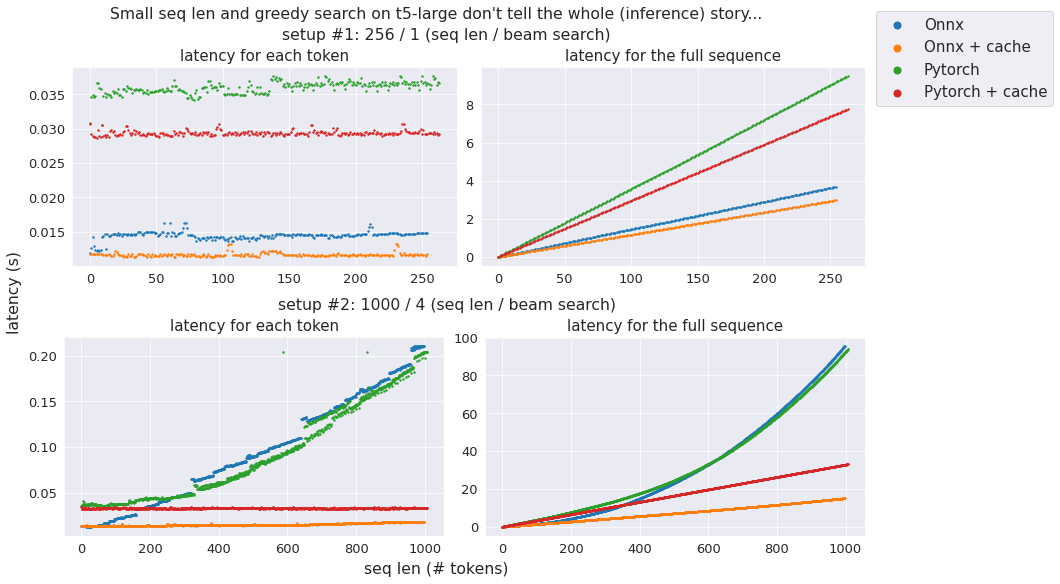

In [23]:
sns.set_style("darkgrid")  # darkgrid, whitegrid, dark, white and ticks
plt.rc("axes", titlesize=15)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=13)  # fontsize of the tick labels
plt.rc("ytick", labelsize=13)  # fontsize of the tick labels
plt.rc("legend", fontsize=15)  # legend fontsize
plt.rc("font", size=13)  # controls default text sizes

colors = sns.color_palette("deep")
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
subfigs = fig.subfigures(nrows=2, ncols=1)

fig.supxlabel("seq len (# tokens)")
fig.supylabel("latency (s)")
fig.suptitle(f"Small seq len and greedy search on {model_name} don't tell the whole (inference) story...")
for row, (plot_name, timings) in enumerate(all_timings.items()):
    subfigs[row].suptitle(f"setup #{1+row}: {plot_name} (seq len / beam search)")
    axs = subfigs[row].subplots(nrows=1, ncols=2)
    for col, accumulated in enumerate([False, True]):
        plot_axis = axs[col]
        for index, (k, v) in enumerate(timings.items()):
            axis = range(len(v))
            color = colors[index]
            v = np.array(v)
            # remove extreme values
            p99 = np.percentile(v, 99)
            v[v > p99] = p99
            v = np.cumsum(v) if accumulated else v
            plot_axis.scatter(axis, v, label=k, s=2)

        title = f"latency for the full sequence" if accumulated else f"latency for each token"
        plot_axis.title.set_text(title)

# legend deduplication
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 1), loc="upper left", markerscale=5)
plt.show()

## Profiling model at the kernel level

Below we reload the decoder model with Onnx Runtime kernel profiling enabled.
It will help us to understand on which part of the computation graph the GPU spends its time.  

The number of events that Onnx Runtime can save is limited to [1 million](https://github.com/microsoft/onnxruntime/blob/a4b5fa334aa939fb159bdc571ed3d56ca8d31fc7/onnxruntime/core/common/profiler.cc#L10).
It is not an issue as we have seen that timings per token are mostly stable, so having only n first token information don't change anything.

The main information it gives us is that 30% of the time is spent on matrix multiplication when caching is used.  
The rest of the time is spent on mostly memory bound operations:
* element-wise operations which require little computation (`add`, `mul`, `div`, etc.)
* copy pasting tensors `GPU` <-> `GPU` with little transformation in between (`transpose`, `concat`, `cast`, etc.)

It matches the information provided by both `nvidia-smi` and `Nvidia Nsight` (the GPU profiler from Nvidia): the GPU is under utilized.  
That's why we think that a tool like `TensorRT` which will perform aggressive kernel fusion, reducing time spent on memory bounded operations, is a good fit for autoregressive models.

> there is a nice opportunity to increase the speedup by reducing the number of casting operations. We keep this work for the future.

## Profiling model at the kernel level

Below we reload the decoder model with Onnx Runtime kernel profiling enabled.
It will help us to understand on which part of the computation graph the GPU spends its time.  

The number of events that Onnx Runtime can save is limited to [1 million](https://github.com/microsoft/onnxruntime/blob/a4b5fa334aa939fb159bdc571ed3d56ca8d31fc7/onnxruntime/core/common/profiler.cc#L10).
It is not an issue as we have seen that timings per token are mostly stable, so having only n first token information don't change anything.

The main information it gives us is that 30% of the time is spent on matrix multiplication when caching is used.  
The rest of the time is spent on mostly memory bound operations:
* element-wise operations which require little computation (`add`, `mul`, `div`, etc.)
* copy pasting tensors `GPU` <-> `GPU` with little transformation in between (`transpose`, `concat`, `cast`, etc.)

It matches the information provided by both `nvidia-smi` and `Nvidia Nsight` (the GPU profiler from Nvidia): the GPU is under utilized.  
That's why we think that a tool like `TensorRT` which will perform aggressive kernel fusion, reducing time spent on memory bounded operations, is a good fit for autoregressive models.

> there is a nice opportunity to increase the speedup by reducing the number of casting operations. We keep this work for the future.

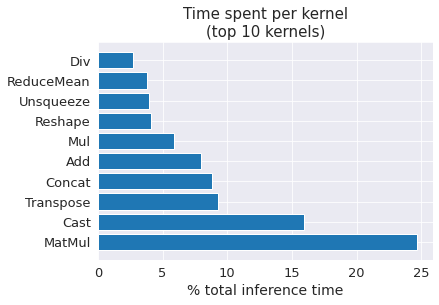

In [24]:
dec_onnx = create_model_for_provider(
    dec_if_fp16_model_path, "CUDAExecutionProvider", enable_profiling=True, log_severity=3
)
dec_onnx_binding: IOBinding = dec_onnx.io_binding()
_ = model_gen.generate(inputs=input_ids, max_length=10, num_beams=num_beam, min_length=10)
profile_name = dec_onnx.end_profiling()

with open(profile_name) as f:
    content = json.load(f)

op_timings = defaultdict(lambda: 0)
for c in content:
    if "op_name" not in c["args"]:
        continue
    op_name = c["args"]["op_name"]
    if op_name == "If":
        continue  # subgraph
    time_taken = c["dur"]
    op_timings[op_name] += time_taken

op_timings_filter = dict(sorted(op_timings.items(), key=operator.itemgetter(1), reverse=True)[:10])
total_kernel_timing = sum(op_timings.values())
op_timings_percent = {k: 100 * v / total_kernel_timing for k, v in op_timings_filter.items()}

plt.barh(list(op_timings_percent.keys()), list(op_timings_percent.values()))
plt.title("Time spent per kernel\n(top 10 kernels)")
plt.xlabel("% total inference time")
plt.show()